In [1]:
import pandas as pd
import numpy as np
from utils import display_eval, analyze_protein_gen_helper

In [2]:
pretrained_file = 'data/baseline_data/distribution/original_old_10_0.5_0_results_merge.csv' 
drakes_file = 'data/baseline_data/distribution/original_new_10_0.5_0_results_merge.csv' 
df_pre = pd.read_csv(pretrained_file)
df_drakes = pd.read_csv(drakes_file)

print("---Pretrained---")
pre_stats = display_eval(df_pre)
print()
print("-----DRAKES-----")
drakes_stats = display_eval(df_drakes)

---Pretrained---
Pred-ddG (median)↑: -0.507
%(ddG > 0) (%)↑: 36.7
scRMSD (median)↓: 0.834
%(scRMSD < 2)(%)↑: 90.0
Success Rate (%)↑: 34.4

-----DRAKES-----
Pred-ddG (median)↑: 1.084
%(ddG > 0) (%)↑: 86.6
scRMSD (median)↓: 0.913
%(scRMSD < 2)(%)↑: 92.4
Success Rate (%)↑: 79.4


In [3]:
def analyze_protein_gen(protein_name):
  analyze_protein_gen_helper(protein_name, [df_pre, df_drakes], ['Pretrained', 'DRAKES'], ['#E6D983', '#0C8CE1'])

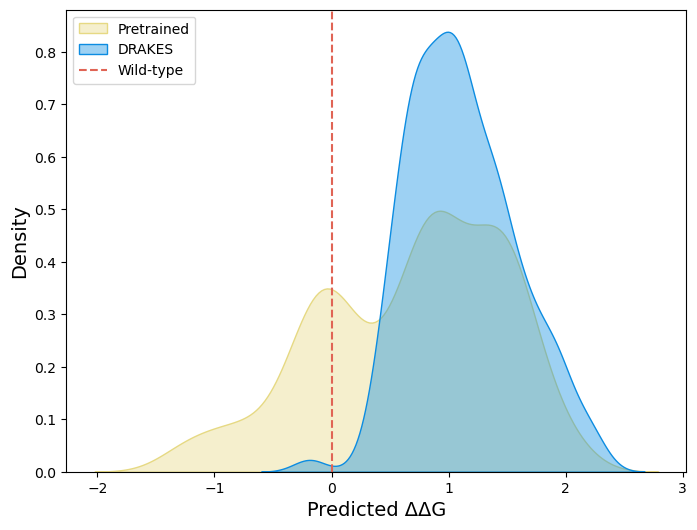

In [4]:
analyze_protein_gen('7JJK')

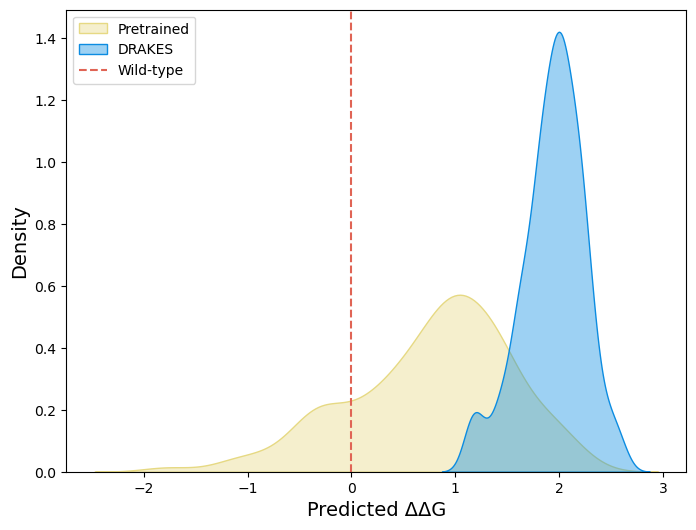

In [5]:
analyze_protein_gen('2KRU')

In [6]:
import torch
import esm
import time
import biotite.structure.io as bsio

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

[2025-03-09 18:20:55,904] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/shai/.conda/envs/multiflow/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/shai/.conda/envs/multiflow/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [7]:
from pyrosetta.rosetta.core.pack.task import TaskFactory
from pyrosetta.rosetta.protocols.minimization_packing import PackRotamersMover
from pyrosetta.rosetta.protocols.relax import FastRelax
from pyrosetta.rosetta.core.pack.task.operation import RestrictToRepacking
from pyrosetta import *
pyrosetta.init(extra_options="-out:level 100")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org


In [22]:
# Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
# Lower sizes will have lower memory requirements at the cost of increased speed.
# model.set_chunk_size(128)
seq = "AVKDAFQVWAAEMYPLVATLFPDWNEWQLNELLRRIWALLTPEQKLPYILRALALAL"
true_seq = "RPMNAFMVWARIHRPALAKANPAANNAEISVQLGLEWNKLSEEQKKPYYDEAQKIKE"
# Multimer prediction can be done with chains separated by ':'

start = time.time()
with torch.no_grad():
    output = model.infer_pdb(seq)
with torch.no_grad():
    true_output = model.infer_pdb(true_seq)
end = time.time()
print(f"Inference time: {end - start}")


Inference time: 1.715916633605957


In [ ]:
with open("result.pdb", "w") as f:
    f.write(output)
with open("true_result.pdb", "w") as f:
    f.write(true_output)

struct = bsio.load_structure("result.pdb", extra_fields=["b_factor"])
true_struct = bsio.load_structure("true_result.pdb", extra_fields=["b_factor"])
print(struct.b_factor.mean())  # this will be the pLDDT

87.67273109243698


In [14]:
def get_pose(gen_folded_pdb_path):
    pose = pyrosetta.pose_from_file(gen_folded_pdb_path)
    # scorefxn = pyrosetta.create_score_function("ref2015_cart")
    # tf = TaskFactory()
    # tf.push_back(RestrictToRepacking())
    # packer = PackRotamersMover(scorefxn, tf.create_task_and_apply_taskoperations(pose))
    # packer.apply(pose)
    # relax = FastRelax()
    # relax.set_scorefxn(scorefxn)
    # relax.apply(pose)
    return pose

pose = get_pose("result.pdb")
true_pose = get_pose("true_result.pdb")

In [15]:
gen_true_bbrmsd = pyrosetta.rosetta.core.scoring.bb_rmsd(true_pose, pose)
print(gen_true_bbrmsd)

2.0485775470733643


In [19]:
print(type(true_pose))

<class 'pyrosetta.rosetta.core.pose.Pose'>
